#Week3 demos and solutions to optional exercises

##Histogram equalization

In [2]:
%matplotlib inline

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.cm as cm
import cv2

In [5]:
# Calculate PSNR for image quality comparison
def psnr(i0, i1):
    mse = np.mean(np.square(i0 - i1))
    if mse == 0:  # prevent errors with log(0)
        mse = np.finfo(float).eps
    return np.round(20 * np.log10(255) - 10*np.log10(mse), 2)

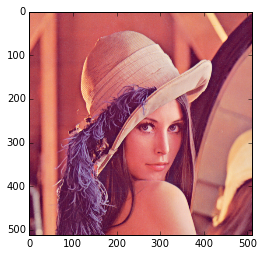

In [34]:
img_file = 'images/4.2.04.tiff'
img_color = mpimg.imread(img_file)
imgplt = plt.imshow(img_color)

Below, convert RGB color image to grayscale image using OpenCV

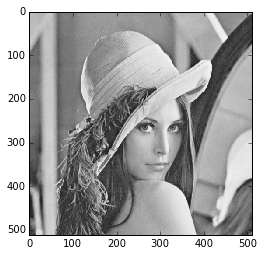

In [35]:
# Convert RGB to grayscale
img = cv2.cvtColor(cv2.merge((img_color[:,:,2], img_color[:,:,1], img_color[:,:,0])), cv2.COLOR_BGR2GRAY)
img = cv2.cvtColor(img_color, cv2.COLOR_RGB2GRAY)

# plot function
myplot = lambda i: plt.imshow(i, cmap=cm.Greys_r, vmin=0, vmax=255, interpolation="nearest")

imgplt = myplot(img)

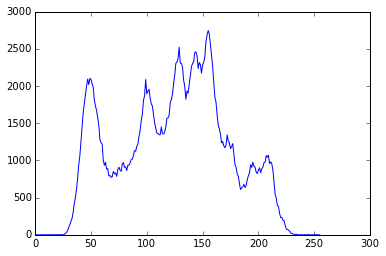

In [36]:
# histogram
hist, bins = np.histogram(img, bins=256, range=(0, 256))
imgplt = plt.plot(bins[:-1], hist)

###Invert image

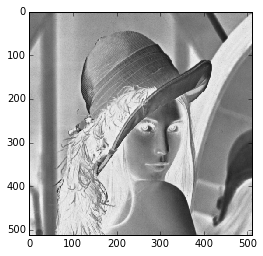

In [12]:
# Create negative
img_negative = 255 - img

imgplts = myplot(img_negative)

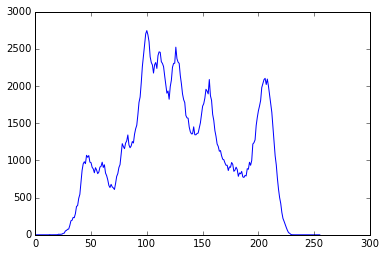

In [13]:
# histogram
hist_negative, bins_negative = np.histogram(img_negative, bins=256, range=(0, 256))
imgplt = plt.plot(bins_negative[:-1], hist_negative)

###Create histogram transform function T(s)

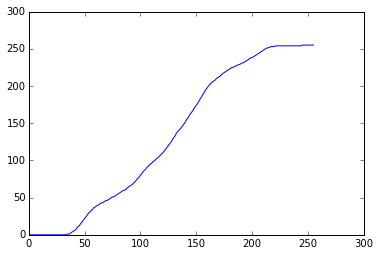

In [14]:
# generate transform function T(s) (CDF) from img's histogram (PDF)
T = hist.cumsum()
T = 255*T/T[-1]

imgplt = plt.plot(bins[:-1], T)

###Equalize histogram

In [15]:
# function to equlize image
def equalize_image(i):
    hist, bins = np.histogram(i, bins=256, range=(0, 256), density=True)
    dist = (255 * hist.cumsum()).astype(np.uint8)
    return np.interp(i, bins[:-1], dist)


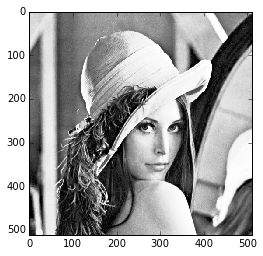

In [16]:
img_ge = equalize_image(img)
imgplts = myplot(img_ge)

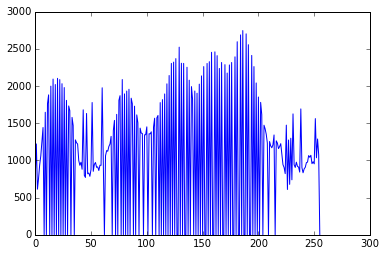

In [17]:
# histogram
hist, bins = np.histogram(img_ge, bins=256, range=(0, 256))
imgplt = plt.plot(bins[:-1], hist)

Transform function T(s) should be identity for an equalized image

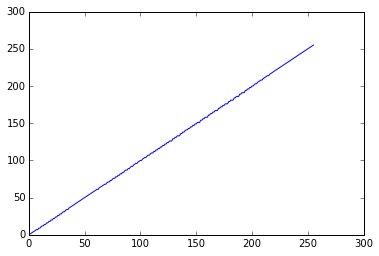

In [18]:
# Transform function T(s)
T = hist.cumsum()
T = 255*T/T[-1]

imgplt = plt.plot(bins[:-1], T)

###Equalize histogram with OpenCV

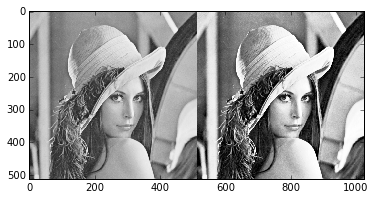

In [19]:
equ = cv2.equalizeHist(img)

res = np.hstack((img,equ)) #stacking images side-by-side
imgplts = myplot(res)

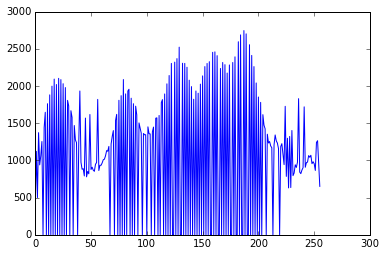

In [20]:
# histogram
hist, bins = np.histogram(equ, bins=256, range=(0, 256))
imgplt = plt.plot(bins[:-1], hist)

## Histogram matching
Match histogram of an image based on the histogram of a second image. Can be easily modified to accept a target histogram instead of an image.
Credits Victor Zaguskin http://vzaguskin.github.io/

In [21]:
# Function to match a histogram based on a second image
def histogram_match(i1, i2):
    hist1, bins = np.histogram(i1, bins=256, range=(0, 256), density=True)
    if i2.shape == i1.shape:
        hist2, bins = np.histogram(i2, bins=256, range=(0, 256), density=True)
    elif i2.shape == hist1.shape:
        hist2 = i2
    dist1 = (255 * hist1.cumsum()).astype(np.uint8)
    dist2 = (255 * hist2.cumsum()).astype(np.uint8)
    return np.interp(np.interp(i1, bins[:-1], dist1), dist2, bins[:-1])

Match histogram of an image to it's own histogram. This is identity operation, ie. the resulting image should be the same as the original image.

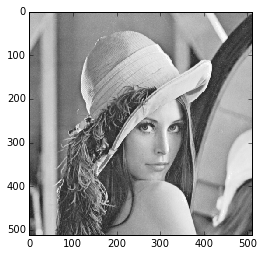

In [22]:
img_m = histogram_match(img, img)
imgplts = myplot(img_m)

The overall shapes and most of the values match, but we see some interpolation errors which can be eliminated with an alternative interpolation function than is better suited for imaging apllications that numpy's interpolation function.

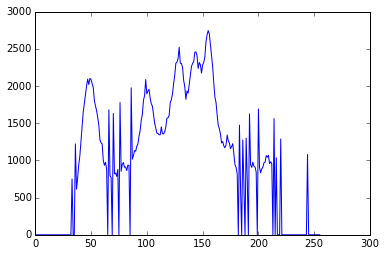

In [23]:
# histogram
hist, bins = np.histogram(img_m, bins=256, range=(0, 256))
imgplt = plt.plot(bins[:-1], hist)

PSNR for comparison

In [24]:
print 'PSNR(histogram self match) =', psnr(img, img_m)

PSNR(histogram self match) = 45.63


##Non-local Means
IPOL: http://www.ipol.im/pub/art/2011/bcm_nlm/

scikit-image: http://scikit-image.org/docs/0.11.x/api/skimage.restoration.html#nl-means-denoising

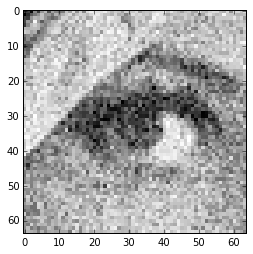

In [26]:
noise = np.random.normal(0, 25, img.shape[:2]).astype(np.int)
img_noisy = np.empty_like(img)
np.clip(img + noise, 0, 255, img_noisy)
imgplts = myplot(img_noisy[232:296,232:296])

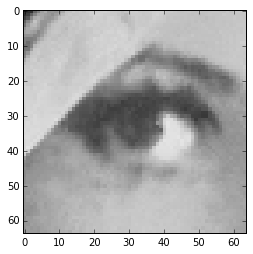

In [27]:
from skimage.restoration import nl_means_denoising
img_denoised = nl_means_denoising(img_noisy, patch_size=5, patch_distance=11, h=25, fast_mode=True)
imgplts = myplot(img_denoised[232:296,232:296])

Calculate PSNR

In [28]:
print 'PSNR(noisy) =', psnr(img, img_noisy)
print 'PSNR(denoised) =', psnr(img, img_denoised)

PSNR(noisy) = 28.48
PSNR(denoised) = 29.55


##Median Filering

###Gaussian noise

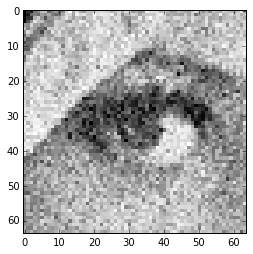

In [56]:
noise = np.random.normal(0, 25, img.shape[:2]).astype(np.int)
np.clip(img + noise, 0, 255, img_noisy)
imgplts = myplot(img_noisy[232:296,232:296])

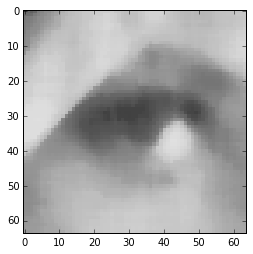

In [57]:
img_denoised = cv2.medianBlur(img_noisy.astype(np.uint8), 9)
imgplts = myplot(img_denoised[232:296,232:296])

Calculate PSNR

In [58]:
print 'PSNR(noisy) =', psnr(img, img_noisy)
print 'PSNR(denoised) =', psnr(img, img_denoised)

PSNR(noisy) = 28.49
PSNR(denoised) = 31.8


###Unsharp masking to sharpen edges

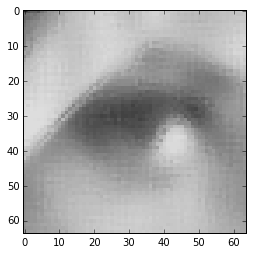

In [88]:
# apply averaging filter
k = 3
kernel = np.ones((k,k))/(k*k)
img_unsharp = cv2.filter2D(img_denoised, -1, kernel)

# edges
e = img_unsharp.astype(np.int) - img_denoised.astype(np.int)

#sharpen
alpha = 3
img_sharp = np.clip(img_denoised + alpha * e, 0, 255).astype(np.uint8)
imgplts = myplot(img_sharp[232:296,232:296])

In [89]:
print 'PSNR(sharpened) =', psnr(img, img_sharp)

PSNR(sharpened) = 31.46


###Salt & Pepper noise

In [793]:
def salt_pepper(img, r=0.1, sp_ratio=0.5):
    '''
    Function to add random salt & pepper noise
    r: noise percentage
    sp_ratio: salt to pepper ratio
    '''
    
    # Image dimensions
    height, width = img.shape[:2]
    n = np.prod(img.shape[:2])

    m = int(r * n)             # number of noisy pixels
    s = int(sp_ratio * m)     # number of salt pixels

    # get m random coordinates
    img_noisy = np.copy(img)
    for y, x in zip(np.random.randint(0, height, s), np.random.randint(0, width, s)):
        img_noisy[y, x] = 255
    for y, x in zip(np.random.randint(0, height, m - s), np.random.randint(0, width, m - s)):
        img_noisy[y, x] = 0
    return img_noisy

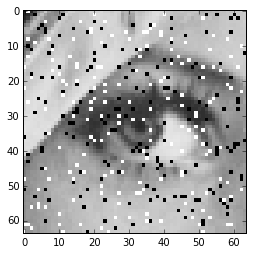

In [801]:
img_noisy = salt_pepper(img, 0.09)
imgplts = myplot(img_noisy[232:296,232:296])

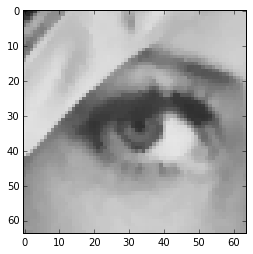

In [806]:
img_denoised = cv2.medianBlur(img_noisy, 3)
imgplts = myplot(img_denoised[232:296,232:296])

Calculate PSNR

In [807]:
print 'PSNR(noisy) =', psnr(img, img_noisy)
print 'PSNR(denoised) =', psnr(img, img_denoised)

PSNR(noisy) = 38.56
PSNR(denoised) = 36.63


Original for comparison

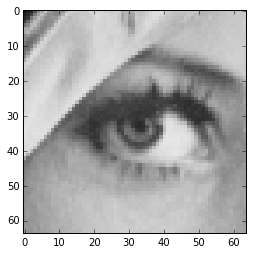

In [781]:
# original
imgplts = myplot(img[232:296,232:296])

##Unsharp Masking

Calculate difference between original and denoised from above.

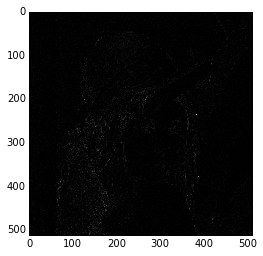

In [782]:
diff = np.abs(img.astype(np.float) - img_denoised.astype(np.float)).astype(np.uint8)
#imgplts = myplot(diff[232:296,232:296])
imgplts = myplot(diff)

Square the difference between original and denoised from above to incease conrast

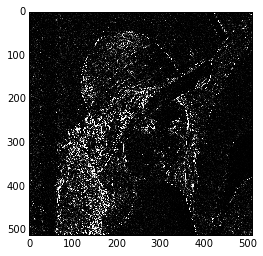

In [783]:
diff_sq = np.power((img.astype(np.float) - img_denoised.astype(np.float)), 2).astype(np.int)
#imgplts = myplot(diff_sq[232:296,232:296])
imgplts = myplot(diff_sq)

##Basic color edge detector

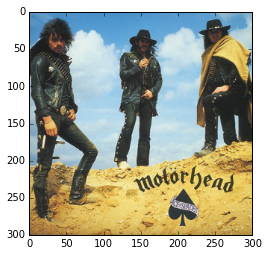

In [7]:
img_file = 'images/ace_of_spades.jpg'
img_color = mpimg.imread(img_file)

imgplt = plt.imshow(img_color)

###Laplacian: 
http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_imgproc/py_gradients/py_gradients.html

http://docs.opencv.org/2.4/modules/imgproc/doc/filtering.html#laplacian

In [14]:
laplacian = cv2.Laplacian(img_color, ddepth=cv2.CV_64F, scale = 1)
lap_abs = np.sqrt(np.sum(np.square(cv2.Laplacian(img_color,cv2.CV_64F)), axis=2))

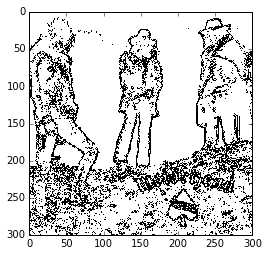

In [15]:
th = np.std(lap_abs)  # use standard deviation as threshold
edges = np.full_like(lap_abs, 255)
edges[lap_abs > th] = 0

imgplt = myplot(edges)

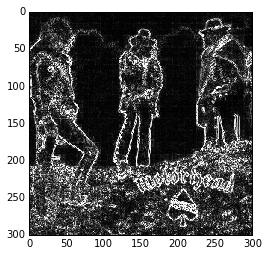

In [33]:
# show the laplacian
imgplt = myplot(lap_abs)